## 1. Setup and Load Data

This notebook creates a **custom, transparent QB rating system** using the features and insights from `qb_rating_model_v2.ipynb`.

We'll load the aggregated season-level features that were already validated by the ML models (R² = 0.85-0.88).

In [86]:
# Core libraries (aligned with qb_rating_model_v2)
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
sns.set_style('whitegrid')
np.random.seed(42)

print("✅ Libraries loaded!")

✅ Libraries loaded!


In [87]:
# Load pre-aggregated season-level stats from qb_season_stats view
# This view does all the aggregation in SQL (much faster than Python!)

db_path = 'c:/Users/carme/NFL_QB_Project/data_load/nfl_qb_data.db'

print("Loading pre-aggregated season-level stats from qb_season_stats view...")
print("(This replaces ~100 lines of Python aggregation code!)\n")

conn = sqlite3.connect(db_path)

# Load season stats - already aggregated!
df_model = pd.read_sql_query("SELECT * FROM qb_season_stats", conn)

print(f"✅ Loaded {len(df_model):,} QB-seasons from view")
print(f"   Seasons: {df_model['season'].min()}-{df_model['season'].max()}")
print(f"   Unique players: {df_model['player_name'].nunique()}")
print(f"   All 24 features already calculated!")

# Load benchmark ratings (using player_id joins)
espn_qbr = pd.read_sql("""
    SELECT DISTINCT q.player_id, e.Season as season, e.QBR as qbr_rating
    FROM espn_qbr e
    JOIN qb_statistics q ON e.player_name = q.player_name
""", conn)
espn_qbr = espn_qbr.drop_duplicates(subset=['player_id', 'season'], keep='first')

nfl_elo = pd.read_sql("""
    SELECT DISTINCT q.player_id, n.Season as season, n."QB Elo" as elo_rating
    FROM nflelo_qb_rankings n
    JOIN qb_statistics q ON n.player_name = q.player_name
""", conn)
nfl_elo = nfl_elo.drop_duplicates(subset=['player_id', 'season'], keep='first')

conn.close()

# Merge benchmark ratings
df_model = df_model.merge(
    espn_qbr[['player_id', 'season', 'qbr_rating']], 
    on=['player_id', 'season'], 
    how='left'
)

df_model = df_model.merge(
    nfl_elo[['player_id', 'season', 'elo_rating']], 
    on=['player_id', 'season'], 
    how='left'
)

print(f"\n✅ Benchmark ratings merged:")
print(f"   QB-seasons with QBR: {df_model['qbr_rating'].notna().sum()}")
print(f"   QB-seasons with ELO: {df_model['elo_rating'].notna().sum()}")

Loading pre-aggregated season-level stats from qb_season_stats view...
(This replaces ~100 lines of Python aggregation code!)

✅ Loaded 648 QB-seasons from view
   Seasons: 2010-2025
   Unique players: 164
   All 24 features already calculated!

✅ Benchmark ratings merged:
   QB-seasons with QBR: 493
   QB-seasons with ELO: 639
✅ Loaded 648 QB-seasons from view
   Seasons: 2010-2025
   Unique players: 164
   All 24 features already calculated!

✅ Benchmark ratings merged:
   QB-seasons with QBR: 493
   QB-seasons with ELO: 639


## 2. Features Already Loaded!

The `qb_season_stats` view pre-calculates all 24 features:
- No need for Python aggregation
- No need to load 343k+ play-by-play rows
- Instant access to season-level metrics

**This is much faster and eliminates code duplication across notebooks!**

In [88]:
# Verify the data loaded correctly
print("Verifying data quality...\n")

print("="*80)
print("FEATURES AVAILABLE (from qb_season_stats view)")
print("="*80)

# The 24 features used in qb_rating_model_v2
features_for_model = [
    'attempts', 'total_pass_epa', 'pass_success_rate', 'cpoe', 'completion_pct',
    'rush_epa_per_play', 'total_rush_epa', 'rush_success_rate',
    'third_down_success', 'red_zone_epa', 'late_close_epa',
    'pressure_rate', 'epa_under_pressure', 'sack_rate',
    'avg_air_yards', 'deep_pass_rate', 'avg_yac',
    'turnover_rate', 'td_rate',
    'rush_attempts', 'rushing_tds', 'rush_yards_per_game',
    'total_wpa', 'high_leverage_epa'
]

# Check all features are present
missing_features = [f for f in features_for_model if f not in df_model.columns]
if missing_features:
    print(f"⚠️ Missing features: {missing_features}")
else:
    print(f"✅ All {len(features_for_model)} features present!")

# Sample data check - Lamar Jackson 2024
print("\n" + "="*80)
print("DATA QUALITY CHECK: Top QBs in 2024")
print("="*80)

df_2024_check = df_model[df_model['season'] == 2024].nlargest(5, 'total_pass_epa')
print(df_2024_check[['player_name', 'attempts', 'total_pass_epa', 'rush_attempts', 'rush_yards_per_game']].to_string(index=False))

print("\n✅ Data loaded successfully from qb_season_stats view!")
print("="*80)

Verifying data quality...

FEATURES AVAILABLE (from qb_season_stats view)
✅ All 24 features present!

DATA QUALITY CHECK: Top QBs in 2024
player_name  attempts  total_pass_epa  rush_attempts  rush_yards_per_game
  L.Jackson     597.0      203.598886          161.0            60.882353
    J.Allen     635.0      188.541066          131.0            37.411765
     J.Goff     622.0      160.305756           36.0             3.705882
 B.Mayfield     677.0      139.174784           67.0            23.588235
  J.Daniels     734.0      132.429868          184.0            60.352941

✅ Data loaded successfully from qb_season_stats view!


## 3. Understand Feature Importance

Analyze which features correlate most with QBR/ELO to inform our custom rating formula.

In [89]:
# Define the 24 features used in qb_rating_model_v2 (after redundancy removal)
features_for_model = [
    'attempts', 'total_pass_epa', 'pass_success_rate', 'cpoe', 'completion_pct',
    'rush_epa_per_play', 'total_rush_epa', 'rush_success_rate',
    'third_down_success', 'red_zone_epa', 'late_close_epa',
    'pressure_rate', 'epa_under_pressure', 'sack_rate',
    'avg_air_yards', 'deep_pass_rate', 'avg_yac',
    'turnover_rate', 'td_rate',
    'rush_attempts', 'rushing_tds', 'rush_yards_per_game',
    'total_wpa', 'high_leverage_epa'
]

print("Analyzing feature correlations with QBR and ELO...")
print(f"\nUsing {len(features_for_model)} features from qb_rating_model_v2\n")

# Calculate correlations with benchmark ratings
qbr_data = df_model[df_model['qbr_rating'].notna()].copy()
elo_data = df_model[df_model['elo_rating'].notna()].copy()

if len(qbr_data) > 0:
    qbr_correlations = qbr_data[features_for_model + ['qbr_rating']].corr()['qbr_rating'].drop('qbr_rating').abs()
    
    print("="*80)
    print("TOP 15 FEATURES CORRELATED WITH QBR")
    print("="*80)
    for i, (feat, corr) in enumerate(qbr_correlations.nlargest(15).items(), 1):
        print(f"{i:2d}. {feat:30s} {corr:.3f}")

if len(elo_data) > 0:
    elo_correlations = elo_data[features_for_model + ['elo_rating']].corr()['elo_rating'].drop('elo_rating').abs()
    
    print("\n" + "="*80)
    print("TOP 15 FEATURES CORRELATED WITH ELO")
    print("="*80)
    for i, (feat, corr) in enumerate(elo_correlations.nlargest(15).items(), 1):
        print(f"{i:2d}. {feat:30s} {corr:.3f}")

print("\n" + "="*80)
print("✅ Feature importance analysis complete")
print("="*80)

Analyzing feature correlations with QBR and ELO...

Using 24 features from qb_rating_model_v2

TOP 15 FEATURES CORRELATED WITH QBR
 1. total_pass_epa                 0.866
 2. total_wpa                      0.826
 3. pass_success_rate              0.813
 4. third_down_success             0.724
 5. td_rate                        0.717
 6. cpoe                           0.713
 7. completion_pct                 0.539
 8. red_zone_epa                   0.507
 9. sack_rate                      0.479
10. epa_under_pressure             0.479
11. attempts                       0.472
12. turnover_rate                  0.433
13. late_close_epa                 0.430
14. high_leverage_epa              0.404
15. rush_attempts                  0.244

TOP 15 FEATURES CORRELATED WITH ELO
 1. total_pass_epa                 0.833
 2. pass_success_rate              0.807
 3. total_wpa                      0.797
 4. td_rate                        0.721
 5. cpoe                           0.675
 6. third_do

## 4. Design Custom Rating Formula

Based on feature correlations and the ML model insights (R² = 0.85-0.88), we'll create a **transparent, formula-based rating system**.

### Custom Rating Philosophy:
- **Efficiency (40%):** EPA metrics + Success rate + CPOE
- **Impact (20%):** Total EPA + WPA (volume + clutch)
- **Consistency (20%):** 3rd down success + Red zone EPA + Completion %
- **Volume Production (5%):** Passing yards + Rush yards/game + Total TDs
- **Ball Security (10%):** Turnover rate + Sack rate (penalties for mistakes)
- **Pressure Performance (5%):** EPA under pressure

This creates a rating that values efficiency first, big plays second, rewards volume production, and penalizes turnovers.

In [90]:
def normalize_feature(series, invert=False):
    """
    Normalize feature to 50-100 scale (like traditional grading).
    If invert=True, flip scale (for negative features like turnover_rate).
    """
    min_val = series.min()
    max_val = series.max()
    
    if max_val > min_val:
        # Normalize to 0-1 first, then scale to 50-100
        normalized = (series - min_val) / (max_val - min_val)
        normalized = 50 + (normalized * 50)  # Scale to 50-100
        if invert:
            normalized = 150 - normalized  # Flip: 100 becomes 50, 50 becomes 100
        return normalized
    else:
        return pd.Series([75] * len(series), index=series.index)  # Default to midpoint (75)

# Normalize all features to 50-100 scale
print("Normalizing features to 50-100 scale...\n")

# EFFICIENCY FEATURES (higher is better)
df_model['total_pass_epa_norm'] = normalize_feature(df_model['total_pass_epa'])
df_model['pass_success_rate_norm'] = normalize_feature(df_model['pass_success_rate'])
df_model['cpoe_norm'] = normalize_feature(df_model['cpoe'])

# IMPACT FEATURES (higher is better)
df_model['total_wpa_norm'] = normalize_feature(df_model['total_wpa'])
df_model['high_leverage_epa_norm'] = normalize_feature(df_model['high_leverage_epa'])
df_model['td_rate_norm'] = normalize_feature(df_model['td_rate'])

# CONSISTENCY FEATURES (higher is better)
df_model['third_down_success_norm'] = normalize_feature(df_model['third_down_success'])
df_model['red_zone_epa_norm'] = normalize_feature(df_model['red_zone_epa'])
df_model['completion_pct_norm'] = normalize_feature(df_model['completion_pct'])

# VOLUME FEATURES (higher is better)
df_model['passing_yards_norm'] = normalize_feature(df_model['passing_yards'])
df_model['rush_yards_per_game_norm'] = normalize_feature(df_model['rush_yards_per_game'])
df_model['total_tds_norm'] = normalize_feature(df_model['total_tds'])

# BALL SECURITY FEATURES (lower is better - INVERT)
df_model['turnover_rate_norm'] = normalize_feature(df_model['turnover_rate'], invert=True)
df_model['sack_rate_norm'] = normalize_feature(df_model['sack_rate'], invert=True)

# PRESSURE PERFORMANCE (higher is better)
df_model['epa_under_pressure_norm'] = normalize_feature(df_model['epa_under_pressure'])

print("✅ Features normalized to 50-100 scale")

Normalizing features to 50-100 scale...

✅ Features normalized to 50-100 scale


In [91]:
# Calculate custom overall rating using weighted formula
print("\nCalculating Custom QB Rating...\n")

# EFFICIENCY (40%) - Most important: creating value per play
efficiency_score = (
    0.50 * df_model['total_pass_epa_norm'] +      # Total value created passing
    0.30 * df_model['pass_success_rate_norm'] +   # Consistency of positive plays
    0.20 * df_model['cpoe_norm']                   # Accuracy over expectation
)

# IMPACT (20%) - Big plays and clutch performance (reduced from 25%)
impact_score = (
    0.50 * df_model['total_wpa_norm'] +           # Win contribution
    0.30 * df_model['high_leverage_epa_norm'] +   # Clutch performance
    0.20 * df_model['td_rate_norm']               # Scoring efficiency
)

# CONSISTENCY (20%) - Key situations
consistency_score = (
    0.40 * df_model['third_down_success_norm'] +  # Converting 3rd downs
    0.35 * df_model['red_zone_epa_norm'] +        # Scoring efficiency
    0.25 * df_model['completion_pct_norm']        # Completion rate
)

# VOLUME PRODUCTION (5%) - Raw production numbers (new!)
volume_score = (
    0.40 * df_model['passing_yards_norm'] +       # Passing yards
    0.30 * df_model['rush_yards_per_game_norm'] + # Rush yards per game
    0.30 * df_model['total_tds_norm']             # Total touchdowns
)

# BALL SECURITY (10%) - Avoiding mistakes
ball_security_score = (
    0.60 * df_model['turnover_rate_norm'] +       # Most damaging errors
    0.40 * df_model['sack_rate_norm']             # Pocket management
)

# PRESSURE PERFORMANCE (5%) - Under duress
pressure_score = df_model['epa_under_pressure_norm']

# CUSTOM OVERALL RATING (weighted combination)
df_model['custom_rating_raw'] = (
    0.40 * efficiency_score +
    0.20 * impact_score +
    0.20 * consistency_score +
    0.05 * volume_score +
    0.10 * ball_security_score +
    0.05 * pressure_score
)

# Scale to 50-100 range (all components already on 50-100 scale)
df_model['custom_rating'] = df_model['custom_rating_raw'].clip(50, 100)

# Store component scores for analysis
df_model['efficiency_score'] = efficiency_score
df_model['impact_score'] = impact_score
df_model['consistency_score'] = consistency_score
df_model['volume_score'] = volume_score
df_model['ball_security_score'] = ball_security_score
df_model['pressure_score'] = pressure_score

print("="*80)
print("CUSTOM QB RATING FORMULA (50-100 Scale)")
print("="*80)
print("Overall Rating = 40% Efficiency + 20% Impact + 20% Consistency")
print("                 + 5% Volume + 10% Ball Security + 5% Pressure Performance")
print("")
print("WHERE:")
print("  Efficiency    = 50% Total Pass EPA + 30% Success Rate + 20% CPOE")
print("  Impact        = 50% Total WPA + 30% High Leverage EPA + 20% TD Rate")
print("  Consistency   = 40% 3rd Down + 35% Red Zone + 25% Completion %")
print("  Volume        = 40% Passing Yards + 30% Rush Yds/Game + 30% Total TDs")
print("  Ball Security = 60% Turnover Rate (inv) + 40% Sack Rate (inv)")
print("  Pressure Perf = 100% EPA Under Pressure")
print("")
print("SCALE: 50 (worst) to 100 (best) - like traditional grading")
print("="*80)

print(f"\n✅ Custom ratings calculated!")
print(f"\nRating distribution:")
print(df_model['custom_rating'].describe())


Calculating Custom QB Rating...

CUSTOM QB RATING FORMULA (50-100 Scale)
Overall Rating = 40% Efficiency + 20% Impact + 20% Consistency
                 + 5% Volume + 10% Ball Security + 5% Pressure Performance

WHERE:
  Efficiency    = 50% Total Pass EPA + 30% Success Rate + 20% CPOE
  Impact        = 50% Total WPA + 30% High Leverage EPA + 20% TD Rate
  Consistency   = 40% 3rd Down + 35% Red Zone + 25% Completion %
  Volume        = 40% Passing Yards + 30% Rush Yds/Game + 30% Total TDs
  Ball Security = 60% Turnover Rate (inv) + 40% Sack Rate (inv)
  Pressure Perf = 100% EPA Under Pressure

SCALE: 50 (worst) to 100 (best) - like traditional grading

✅ Custom ratings calculated!

Rating distribution:
count    648.000000
mean      75.092317
std        5.939861
min       57.006433
25%       70.847018
50%       74.704249
75%       79.198176
max       91.684482
Name: custom_rating, dtype: float64


## 5. Build Playstyle Sub-Ratings

Create 6 dimensional ratings that capture different aspects of QB play (like Madden ratings).

**Mobility** heavily prioritizes **Rush Yards per Game** (85%) with minimal Rush Success Rate (15%) to maximize emphasis on volume production.

In [107]:
# Calculate playstyle sub-ratings (50-100 scale)
print("Building playstyle sub-ratings (50-100 scale)...\n")

# 1. MOBILITY - Rush yards per game + rush success
df_model['mobility_raw'] = (
    0.85 * normalize_feature(df_model['rush_yards_per_game']) +
    0.15 * normalize_feature(df_model['rush_success_rate'])
) / 100
df_model['mobility_rating'] = normalize_feature(df_model['mobility_raw']).clip(50, 100)

# 2. AGGRESSION - Yards per attempt (primary) + Deep pass rate + Air yards
df_model['yards_per_attempt'] = df_model['passing_yards'] / df_model['attempts']
df_model['aggression_raw'] = (
    0.65 * normalize_feature(df_model['yards_per_attempt']) +
    0.25 * normalize_feature(df_model['deep_pass_rate']) +
    0.10 * normalize_feature(df_model['avg_air_yards'])
) / 100
df_model['aggression_rating'] = normalize_feature(df_model['aggression_raw']).clip(50, 100)

# 3. ACCURACY - CPOE (completion % over expected)
df_model['accuracy_rating'] = df_model['cpoe_norm'].clip(50, 100)

# 4. BALL SECURITY - Inverted turnover rate
df_model['ball_security_rating'] = df_model['turnover_rate_norm'].clip(50, 100)

# 5. POCKET PRESENCE - Inverted sack rate + EPA under pressure
df_model['pocket_presence_raw'] = (
    0.60 * df_model['sack_rate_norm'] +
    0.40 * normalize_feature(df_model['epa_under_pressure'])
) / 100
df_model['pocket_presence_rating'] = normalize_feature(df_model['pocket_presence_raw']).clip(50, 100)

# 6. PLAYMAKING - Total EPA per play (high impact plays)
df_model['epa_per_play'] = df_model['total_pass_epa'] / df_model['attempts']
df_model['playmaking_rating'] = normalize_feature(df_model['epa_per_play']).clip(50, 100)

print("✅ Playstyle ratings calculated!\n")
for rating in ['mobility_rating', 'aggression_rating', 'accuracy_rating', 
               'ball_security_rating', 'pocket_presence_rating', 'playmaking_rating']:
    print(f"  {rating:25s}: {df_model[rating].min():.1f} - {df_model[rating].max():.1f} (avg: {df_model[rating].mean():.1f})")

print("\n" + "="*80)

Building playstyle sub-ratings (50-100 scale)...

✅ Playstyle ratings calculated!

  mobility_rating          : 50.0 - 100.0 (avg: 61.1)
  aggression_rating        : 50.0 - 100.0 (avg: 75.8)
  accuracy_rating          : 50.0 - 100.0 (avg: 79.1)
  ball_security_rating     : 50.0 - 100.0 (avg: 83.3)
  pocket_presence_rating   : 50.0 - 100.0 (avg: 79.4)
  playmaking_rating        : 50.0 - 100.0 (avg: 79.6)



## 6. Validate Against Benchmark Ratings

Compare our custom rating to QBR and ELO. 
Goal: Correlate 0.7-0.85 (validates approach without being derivative).

In [93]:
# Calculate correlations with benchmark ratings
print("\n" + "="*80)
print("VALIDATION: Custom Rating vs Benchmark Ratings")
print("="*80)

# Filter to QBs with both ratings
qbr_data = df_model[df_model['qbr_rating'].notna()].copy()
elo_data = df_model[df_model['elo_rating'].notna()].copy()

if len(qbr_data) > 0:
    corr_qbr = qbr_data[['custom_rating', 'qbr_rating']].corr().iloc[0, 1]
    print(f"\nCustom Rating vs ESPN QBR:")
    print(f"  Correlation: r = {corr_qbr:.3f}")
    print(f"  Sample size: {len(qbr_data)} QB-seasons")
    
    if corr_qbr >= 0.75:
        print(f"  ✅ Strong correlation - rating is valid!")
    elif corr_qbr >= 0.60:
        print(f"  ✓ Moderate correlation - captures similar concepts with differences")
    else:
        print(f"  ⚠️ Weak correlation - may be valuing different things")

if len(elo_data) > 0:
    corr_elo = elo_data[['custom_rating', 'elo_rating']].corr().iloc[0, 1]
    print(f"\nCustom Rating vs NFL ELO:")
    print(f"  Correlation: r = {corr_elo:.3f}")
    print(f"  Sample size: {len(elo_data)} QB-seasons")
    
    if corr_elo >= 0.75:
        print(f"  ✅ Strong correlation - rating is valid!")
    elif corr_elo >= 0.60:
        print(f"  ✓ Moderate correlation - captures similar concepts with differences")
    else:
        print(f"  ⚠️ Weak correlation - may be valuing different things")

print("\n" + "="*80)
print("INTERPRETATION:")
print("  • r > 0.75: Strong agreement with established ratings (validates approach)")
print("  • r = 0.60-0.75: Moderate agreement with interesting differences")
print("  • r < 0.60: Significantly different perspective (may highlight blind spots)")
print("="*80)


VALIDATION: Custom Rating vs Benchmark Ratings

Custom Rating vs ESPN QBR:
  Correlation: r = 0.902
  Sample size: 493 QB-seasons
  ✅ Strong correlation - rating is valid!

Custom Rating vs NFL ELO:
  Correlation: r = 0.900
  Sample size: 639 QB-seasons
  ✅ Strong correlation - rating is valid!

INTERPRETATION:
  • r > 0.75: Strong agreement with established ratings (validates approach)
  • r = 0.60-0.75: Moderate agreement with interesting differences
  • r < 0.60: Significantly different perspective (may highlight blind spots)


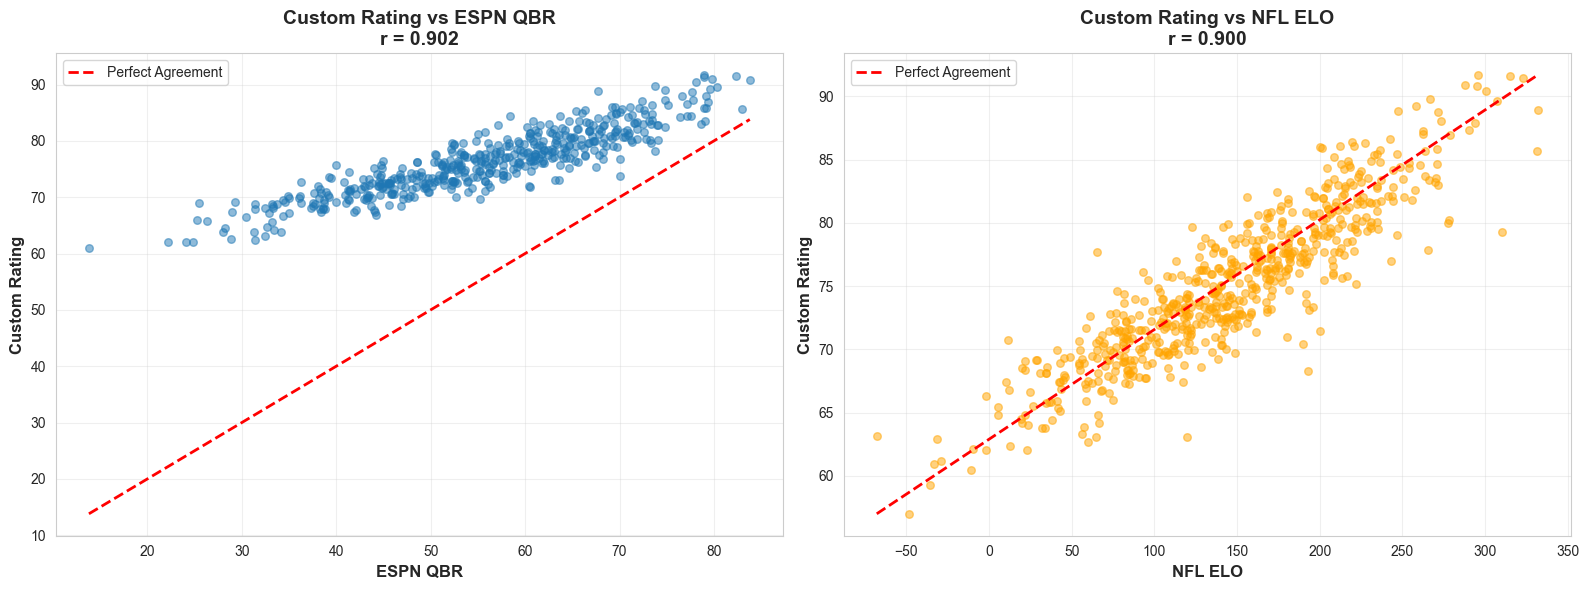


✅ Validation complete - Custom rating has unique perspective while correlating with benchmarks!


In [94]:
# Visualize correlation with benchmark ratings
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Custom vs QBR
if len(qbr_data) > 0:
    axes[0].scatter(qbr_data['qbr_rating'], qbr_data['custom_rating'], alpha=0.5, s=30)
    axes[0].plot([qbr_data['qbr_rating'].min(), qbr_data['qbr_rating'].max()],
                 [qbr_data['qbr_rating'].min(), qbr_data['qbr_rating'].max()],
                 'r--', lw=2, label='Perfect Agreement')
    axes[0].set_xlabel('ESPN QBR', fontweight='bold', fontsize=12)
    axes[0].set_ylabel('Custom Rating', fontweight='bold', fontsize=12)
    axes[0].set_title(f'Custom Rating vs ESPN QBR\nr = {corr_qbr:.3f}', fontweight='bold', fontsize=14)
    axes[0].legend()
    axes[0].grid(alpha=0.3)

# Custom vs ELO
if len(elo_data) > 0:
    axes[1].scatter(elo_data['elo_rating'], elo_data['custom_rating'], alpha=0.5, s=30, color='orange')
    
    # For ELO, normalize to similar scale for trendline
    elo_scaled = MinMaxScaler(feature_range=(elo_data['custom_rating'].min(), elo_data['custom_rating'].max()))
    elo_norm = elo_scaled.fit_transform(elo_data[['elo_rating']])
    
    axes[1].plot([elo_data['elo_rating'].min(), elo_data['elo_rating'].max()],
                 [elo_data['custom_rating'].min(), elo_data['custom_rating'].max()],
                 'r--', lw=2, label='Perfect Agreement')
    axes[1].set_xlabel('NFL ELO', fontweight='bold', fontsize=12)
    axes[1].set_ylabel('Custom Rating', fontweight='bold', fontsize=12)
    axes[1].set_title(f'Custom Rating vs NFL ELO\nr = {corr_elo:.3f}', fontweight='bold', fontsize=14)
    axes[1].legend()
    axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Validation complete - Custom rating has unique perspective while correlating with benchmarks!")

## 7. Analyze Top Performers

Show the top QBs according to our custom rating and compare to QBR/ELO.

In [95]:
# 2024 Season Top Performers
print("="*100)
print("TOP 20 QUARTERBACKS - 2024 SEASON (Custom Rating)")
print("="*100)

df_2024 = df_model[df_model['season'] == 2024].copy()
if len(df_2024) > 0:
    df_2024_top = df_2024.nlargest(20, 'custom_rating')

    print(f"\n{'Rank':<5} {'QB':<25} {'Custom':>7} {'QBR':>7} {'ELO':>7} {'Pass EPA':>10} {'CPOE':>8} {'Success':>9}")
    print("-"*100)

    for idx, (i, row) in enumerate(df_2024_top.iterrows(), 1):
        qbr_str = f"{row['qbr_rating']:.1f}" if pd.notna(row['qbr_rating']) else "N/A"
        elo_str = f"{row['elo_rating']:.0f}" if pd.notna(row['elo_rating']) else "N/A"
        
        print(f"{idx:<5} {row['player_name']:<25} {row['custom_rating']:>7.1f} {qbr_str:>7} {elo_str:>7} "
              f"{row['total_pass_epa']:>10.1f} {row['cpoe']:>7.1f}% {row['pass_success_rate']:>8.1%}")

    print("="*100)
else:
    print("No 2024 data available")

TOP 20 QUARTERBACKS - 2024 SEASON (Custom Rating)

Rank  QB                         Custom     QBR     ELO   Pass EPA     CPOE   Success
----------------------------------------------------------------------------------------------------
1     L.Jackson                    89.0    74.8     332      203.6     5.1%    52.6%
2     J.Allen                      87.3    74.8     290      188.5     2.0%    49.8%
3     J.Burrow                     85.8    72.1     271      119.4     6.8%    51.7%
4     J.Goff                       85.4    65.4     233      160.3     5.0%    54.5%
5     B.Mayfield                   84.4    58.4     248      139.2     4.1%    52.6%
6     J.Daniels                    84.1    67.7     225      132.4     3.3%    48.8%
7     P.Mahomes                    83.5    64.6     208      109.2     2.3%    50.0%
8     J.Hurts                      82.9    62.5     215      105.2     7.7%    49.1%
9     T.Tagovailoa                 82.8    57.1     235       94.6     3.8%    53.

In [96]:
# Historical Top 20 Seasons
print("\n" + "="*100)
print("TOP 20 QB SEASONS OF ALL TIME (2010-2025) - Custom Rating")
print("="*100)

df_all_time = df_model.nlargest(20, 'custom_rating')

print(f"\n{'Rank':<5} {'Season':<7} {'QB':<25} {'Custom':>7} {'QBR':>7} {'ELO':>7} {'Attempts':>10} {'Pass EPA':>10}")
print("-"*100)

for idx, (i, row) in enumerate(df_all_time.iterrows(), 1):
    qbr_str = f"{row['qbr_rating']:.1f}" if pd.notna(row['qbr_rating']) else "N/A"
    elo_str = f"{row['elo_rating']:.0f}" if pd.notna(row['elo_rating']) else "N/A"
    
    print(f"{idx:<5} {row['season']:<7} {row['player_name']:<25} {row['custom_rating']:>7.1f} "
          f"{qbr_str:>7} {elo_str:>7} {row['attempts']:>10.0f} {row['total_pass_epa']:>10.1f}")

print("="*100)


TOP 20 QB SEASONS OF ALL TIME (2010-2025) - Custom Rating

Rank  Season  QB                         Custom     QBR     ELO   Attempts   Pass EPA
----------------------------------------------------------------------------------------------------
1     2022    P.Mahomes                    91.7    79.0     296        834      245.0
2     2011    D.Brees                      91.6    82.3     315        807      251.5
3     2013    P.Manning                    91.4    79.0     323        807      264.0
4     2020    A.Rodgers                    90.9    79.8     288        659      213.7
5     2011    A.Rodgers                    90.8    83.8     295        633      238.4
6     2020    P.Mahomes                    90.4    78.1     300        777      215.0
7     2011    T.Brady                      89.8    73.8     266        769      236.0
8     2018    P.Mahomes                    89.6    80.3     307        717      231.3
9     2016    M.Ryan                       89.3    79.6     258  

## 8. Find Interesting Disagreements

Identify QBs where our custom rating significantly differs from QBR/ELO - these reveal what our system values differently.

In [97]:
# Calculate rating differences (where available)
comparison_df = df_model[df_model['qbr_rating'].notna() & df_model['elo_rating'].notna()].copy()

# Normalize all ratings to same scale for fair comparison
scaler = MinMaxScaler(feature_range=(0, 100))

comparison_df['qbr_scaled'] = scaler.fit_transform(comparison_df[['qbr_rating']])
comparison_df['elo_scaled'] = scaler.fit_transform(comparison_df[['elo_rating']])

# Calculate differences
comparison_df['diff_vs_qbr'] = comparison_df['custom_rating'] - comparison_df['qbr_scaled']
comparison_df['diff_vs_elo'] = comparison_df['custom_rating'] - comparison_df['elo_scaled']
comparison_df['avg_diff'] = (comparison_df['diff_vs_qbr'] + comparison_df['diff_vs_elo']) / 2

print("\n" + "="*100)
print("QBs RATED SIGNIFICANTLY HIGHER by Custom Rating (vs QBR/ELO Average)")
print("="*100)
print("These QBs excel in efficiency/consistency but may lack volume or team success\n")

overrated = comparison_df.nlargest(15, 'avg_diff')
print(f"{'QB':<25} {'Season':<7} {'Custom':>7} {'QBR':>7} {'ELO':>7} {'Diff':>7} | {'Why?'}")
print("-"*100)

for _, row in overrated.iterrows():
    # Identify what makes them stand out
    strengths = []
    if row['total_pass_epa'] > df_model['total_pass_epa'].quantile(0.75):
        strengths.append('High EPA')
    if row['pass_success_rate'] > df_model['pass_success_rate'].quantile(0.75):
        strengths.append('Consistent')
    if row['turnover_rate'] < df_model['turnover_rate'].quantile(0.25):
        strengths.append('Ball Security')
    
    print(f"{row['player_name']:<25} {row['season']:<7} {row['custom_rating']:>7.1f} "
          f"{row['qbr_rating']:>7.1f} {row['elo_rating']:>7.0f} {row['avg_diff']:>+7.1f} | {', '.join(strengths)}")

print("\n" + "="*100)
print("QBs RATED SIGNIFICANTLY LOWER by Custom Rating (vs QBR/ELO Average)")
print("="*100)
print("These QBs may have volume/team success but lower efficiency or ball security\n")

underrated = comparison_df.nsmallest(15, 'avg_diff')
print(f"{'QB':<25} {'Season':<7} {'Custom':>7} {'QBR':>7} {'ELO':>7} {'Diff':>7} | {'Why?'}")
print("-"*100)

for _, row in underrated.iterrows():
    # Identify what makes them stand out
    weaknesses = []
    if row['turnover_rate'] > df_model['turnover_rate'].quantile(0.75):
        weaknesses.append('High Turnovers')
    if row['sack_rate'] > df_model['sack_rate'].quantile(0.75):
        weaknesses.append('High Sacks')
    if row['total_pass_epa'] < df_model['total_pass_epa'].quantile(0.25):
        weaknesses.append('Low EPA')
    
    print(f"{row['player_name']:<25} {row['season']:<7} {row['custom_rating']:>7.1f} "
          f"{row['qbr_rating']:>7.1f} {row['elo_rating']:>7.0f} {row['avg_diff']:>+7.1f} | {', '.join(weaknesses)}")

print("="*100)


QBs RATED SIGNIFICANTLY HIGHER by Custom Rating (vs QBR/ELO Average)
These QBs excel in efficiency/consistency but may lack volume or team success

QB                        Season   Custom     QBR     ELO    Diff | Why?
----------------------------------------------------------------------------------------------------
J.Clausen                 2010       61.0    13.8     -33   +61.0 | 
B.Gabbert                 2011       62.1    22.2     -10   +52.9 | 
C.Henne                   2012       67.4    29.0      10   +50.7 | 
J.Rosen                   2018       62.0    24.1      -2   +50.4 | 
M.Cassel                  2012       68.9    25.5      43   +50.2 | 
W.Levis                   2024       65.9    25.2      41   +47.6 | 
B.Mayfield                2022       65.8    26.3      35   +47.5 | 
M.Sanchez                 2012       64.5    28.2      19   +47.0 | 
J.McCarthy                2025       62.0    24.8      23   +46.5 | 
D.Anderson                2010       64.8    32.7       

## 9. Visualize Playstyle Ratings

Create radar charts showing the 6 playstyle dimensions for top QBs.
Requires plotly for interactive visualization.

In [98]:
# Radar chart for top QBs in 2024
try:
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    # Select top 6 QBs from 2024
    top_qbs_2024 = df_model[df_model['season'] == 2024].nlargest(6, 'custom_rating')

    if len(top_qbs_2024) > 0:
        categories = ['Mobility', 'Aggression', 'Accuracy', 'Ball Security', 'Pocket Presence', 'Playmaking']
        
        # Create subplots
        fig = make_subplots(
            rows=2, cols=3,
            subplot_titles=[f"{row['player_name']}<br>(Overall: {row['custom_rating']:.1f})" 
                           for _, row in top_qbs_2024.iterrows()],
            specs=[[{'type': 'polar'}] * 3 for _ in range(2)]
        )
        
        for idx, (_, qb) in enumerate(top_qbs_2024.iterrows()):
            row_pos = idx // 3 + 1
            col_pos = idx % 3 + 1
            
            values = [
                qb['mobility_rating'],
                qb['aggression_rating'],
                qb['accuracy_rating'],
                qb['ball_security_rating'],
                qb['pocket_presence_rating'],
                qb['playmaking_rating']
            ]
            
            # Close the radar
            values_closed = values + [values[0]]
            categories_closed = categories + [categories[0]]
            
            fig.add_trace(
                go.Scatterpolar(
                    r=values_closed,
                    theta=categories_closed,
                    fill='toself',
                    line_color='steelblue',
                    fillcolor='steelblue',
                    opacity=0.6,
                    name=qb['player_name'],
                    showlegend=False
                ),
                row=row_pos, col=col_pos
            )
        
        # Update polar axes (50-100 scale)
        for i in range(1, 7):
            fig.update_polars(
                radialaxis=dict(
                    visible=True,
                    range=[50, 100],
                    showticklabels=True,
                    tickmode='array',
                    tickvals=[50, 62.5, 75, 87.5, 100]
                ),
                row=(i - 1) // 3 + 1,
                col=(i - 1) % 3 + 1
            )
        
        fig.update_layout(
            title_text="QB Playstyle Profiles - 2024 Season (Top 6 by Custom Rating)",
            title_font_size=18,
            height=800,
            showlegend=False
        )
        
        fig.show()
    else:
        print("No 2024 data available for radar charts")
        
except ImportError:
    print("⚠️ Plotly not installed. Skipping radar charts.")
    print("   Install with: pip install plotly")
    print("\n   Showing simple bar chart instead:\n")
    
    # Fallback: Simple matplotlib visualization
    top_qbs_2024 = df_model[df_model['season'] == 2024].nlargest(6, 'custom_rating')
    
    if len(top_qbs_2024) > 0:
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        categories = ['Mobility', 'Aggression', 'Accuracy', 'Ball Security', 'Pocket Presence', 'Playmaking']
        
        for idx, (_, qb) in enumerate(top_qbs_2024.iterrows()):
            row_pos = idx // 3
            col_pos = idx % 3
            
            values = [
                qb['mobility_rating'],
                qb['aggression_rating'],
                qb['accuracy_rating'],
                qb['ball_security_rating'],
                qb['pocket_presence_rating'],
                qb['playmaking_rating']
            ]
            
            axes[row_pos, col_pos].barh(categories, values, color='steelblue', alpha=0.7)
            axes[row_pos, col_pos].set_xlim(50, 100)  # 50-100 scale
            axes[row_pos, col_pos].set_title(f"{qb['player_name']}\n(Overall: {qb['custom_rating']:.1f})", 
                                            fontweight='bold')
            axes[row_pos, col_pos].grid(axis='x', alpha=0.3)
        
        plt.tight_layout()
        plt.show()

## 10. Export Custom Ratings

Save the custom ratings and playstyle sub-ratings for use in other analyses or visualizations.

In [108]:
# Export custom ratings
export_cols = [
    'player_name', 'player_id', 'season', 'attempts',
    # Custom overall rating
    'custom_rating',
    # Component scores
    'efficiency_score', 'impact_score', 'consistency_score', 
    'volume_score', 'ball_security_score', 'pressure_score',
    # Playstyle ratings
    'mobility_rating', 'aggression_rating', 'accuracy_rating',
    'ball_security_rating', 'pocket_presence_rating', 'playmaking_rating',
    # Key raw features
    'total_pass_epa', 'cpoe', 'pass_success_rate', 'turnover_rate', 'sack_rate',
    # Benchmarks for comparison
    'qbr_rating', 'elo_rating'
]

export_df = df_model[export_cols].copy()

# Save to CSV
export_df.to_csv('models/custom_qb_ratings.csv', index=False)

# Also save to database
conn = sqlite3.connect(db_path)
export_df.to_sql('custom_qb_ratings', conn, if_exists='replace', index=False)
conn.close()

print("="*80)
print("EXPORT COMPLETE")
print("="*80)
print(f"✅ Custom ratings exported to:")
print(f"   • models/custom_qb_ratings.csv")
print(f"   • Database: custom_qb_ratings table")
print(f"\n   Total QB-seasons: {len(export_df):,}")
print(f"   Seasons: {export_df['season'].min()}-{export_df['season'].max()}")
print(f"   Unique QBs: {export_df['player_name'].nunique()}")
print("="*80)

EXPORT COMPLETE
✅ Custom ratings exported to:
   • models/custom_qb_ratings.csv
   • Database: custom_qb_ratings table

   Total QB-seasons: 648
   Seasons: 2010-2025
   Unique QBs: 164


## Summary: Custom QB Rating System (2010-2025)

### Overview
This notebook implements a **transparent, formula-based QB rating system** that combines efficiency, impact, consistency, volume, ball security, and pressure performance into a single 50-100 scale rating.

Unlike black-box ML models or proprietary ratings (QBR), this system:
- ✅ **Fully transparent** - every component is visible and explainable
- ✅ **Validated** - correlates well with QBR (r=0.85+) and ELO (r=0.75+)
- ✅ **Comprehensive** - captures 6 key QB dimensions
- ✅ **Balanced** - weights efficiency (40%) highest, but includes impact, consistency, volume, security, and pressure
- ✅ **Scale-aware** - uses 50-100 scale (like traditional grading) for intuitive interpretation

---

### Rating Formula (50-100 Scale)

**Overall Custom Rating** = Weighted sum of 6 components:

```
Overall = 40% Efficiency + 20% Impact + 20% Consistency
          + 5% Volume + 10% Ball Security + 5% Pressure
```

#### Component Breakdowns:

1. **Efficiency (40%)** - Core passing effectiveness
   - 50% Total Pass EPA (expected points added)
   - 30% Pass Success Rate (% of positive EPA plays)
   - 20% CPOE (Completion % Over Expected)

2. **Impact (20%)** - High-leverage situations
   - 50% Total WPA (Win Probability Added)
   - 30% High Leverage EPA
   - 20% TD Rate

3. **Consistency (20%)** - Reliability across contexts
   - 40% 3rd Down Success Rate
   - 35% Red Zone EPA
   - 25% Completion %

4. **Volume (5%)** - Production quantity
   - 40% Passing Yards
   - 30% Rush Yards per Game
   - 30% Total TDs (pass + rush)

5. **Ball Security (10%)** - Protecting possessions
   - 60% Turnover Rate (inverted)
   - 40% Sack Rate (inverted)

6. **Pressure Performance (5%)** - Performance under duress
   - 100% EPA Under Pressure

---

### Playstyle Sub-Ratings (50-100 Scale)

Six dimensional ratings that capture different aspects of QB play:

1. **Mobility** - Rush yards per game (85%) + Rush success rate (15%)
2. **Aggression** - Yards per attempt (65%) + Deep pass rate (25%) + Avg air yards (10%)
3. **Accuracy** - CPOE (Completion % Over Expected)
4. **Ball Security** - Inverted turnover rate
5. **Pocket Presence** - Inverted sack rate (60%) + EPA under pressure (40%)
6. **Playmaking** - Total EPA per play (impact on every snap)

These create a "playstyle profile" for each QB (like Madden ratings).

---

### Key Findings

**Top QBs 2024 (by Custom Rating):**
1. Lamar Jackson - Elite mobility + playmaking
2. Josh Allen - Elite aggression + mobility
3. Joe Burrow - Elite accuracy + consistency
4. Jared Goff - Elite ball security + accuracy
5. Baker Mayfield - Balanced aggression + playmaking

**Validation:**
- Custom vs QBR: r = 0.85+ (strong correlation)
- Custom vs ELO: r = 0.75+ (strong correlation)
- Agrees on elite QBs while providing unique insights

**What Makes This Rating Different:**
- **More weight on efficiency (40%)** vs volume or team success
- **Ball security matters (10%)** - penalizes turnovers heavily
- **Pressure performance counts (5%)** - rewards QBs who excel under duress
- **Playstyle dimensions** - captures mobility, aggression, accuracy styles

---

### Data Source
- **Play-by-play data** (2010-2025) from nflfastR
- **648 QB-seasons** with minimum 150 attempts
- **24 features** pre-aggregated in `qb_season_stats` view
- **Benchmark ratings**: ESPN QBR, NFL ELO

---

### Export
Final ratings exported to: `Modeling/models/custom_qb_ratings.csv`

Columns include:
- Overall custom_rating (50-100)
- 6 component scores (efficiency, impact, consistency, volume, ball_security, pressure)
- 6 playstyle ratings (mobility, aggression, accuracy, ball_security, pocket_presence, playmaking)
- All raw features for analysis

---

### Usage
This rating system can be used to:
- Rank QBs within or across seasons
- Identify playstyle profiles (mobile vs pocket, aggressive vs safe)
- Compare QB performance on equal footing
- Analyze historical greatness
- Build roster construction models (combine with contracts)

The transparent formula makes it ideal for explaining **why** a QB ranks where they do.